In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
!git clone https://github.com/open-mmlab/mmsegmentation.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
     |████████████████████████████████| 46.6 MB 1.2 MB/s 
     |████████████████████████████████| 190 kB 7.6 MB/s 
Cloning into 'mmsegmentation'...
remote: Enumerating objects: 7170, done.
remote: Counting objects: 100% (182/182), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 7170 (delta 49), reused 160 (delta 39), pack-reused 6988
Receiving objects: 100% (7170/7170), 13.86 MiB | 29.63 MiB/s, done.
Resolving deltas: 100% (5216/5216), done.


In [3]:
import torch

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.11.0+cu113 (Tesla P100-PCIE-16GB)


In [4]:
%cd mmsegmentation

/content/mmsegmentation


In [5]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
import mmcv

In [6]:
import os.path as osp
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [7]:
!mkdir checkpoints
!wget -O //content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth

--2022-05-24 17:34:18--  https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.88.36.72
Connecting to download.openmmlab.com (download.openmmlab.com)|47.88.36.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 328290585 (313M) [application/octet-stream]
Saving to: ‘//content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth’

//content/mmsegment 100%[===================>] 313.08M  10.4MB/s    in 31s     

2022-05-24 17:34:50 (10.1 MB/s) - ‘//content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth’ saved [328290585/328290585]



In [8]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

classes = ('background', 'building')
palette = [[0, 0, 0], [0, 0, 255]]

@DATASETS.register_module()
class SIADataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

In [9]:
# config 파일을 설정하고, 다운로드 받은 pretrained 모델을 checkpoint로 설정. 
config_file = '/content/mmsegmentation/configs/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes.py'
checkpoint_file = '/content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth'

from mmcv import Config

cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

norm_cfg = dict(type='SyncBN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=64,
        num_stages=4,
        num_layers=[3, 6, 40, 3],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        init_cfg=dict(type='Pretrained', checkpoint='pretrain/mit_b5.pth')),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[64, 128, 320, 512],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=19,
        norm_cfg=dict(type='SyncBN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    train_cf

In [10]:
cfg.norm_cfg = dict(type='BN', requires_grad=True)
#cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg

cfg.model.decode_head.num_classes = 2

cfg.model.decode_head.loss_decode = [dict(type='CrossEntropyLoss', loss_weight = 1.0),
                                     dict(type='DiceLoss', loss_weight = 1.0),
                                     dict(type='FocalLoss', loss_weight = 1.0),
                                     dict(type='LovaszLoss', loss_weight = 1.0, reduction='none')]

In [11]:
cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (512, 512)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(1024, 1024), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.val_pipeline = [
                    dict(type='LoadImageFromFile'),
                    dict(
                        type='MultiScaleFlipAug',
                        img_scale=(1024, 1024),
                        flip=False,
                        transforms=[
                                    dict(type='Resize', keep_ratio=True),
                                    dict(type='RandomFlip'),
                                    dict(
                                        type='Normalize',
                                        mean=[123.675, 116.28, 103.53],
                                        std=[58.395, 57.12, 57.375],
                                        to_rgb=True),
                                    dict(type='ImageToTensor', keys=['img']),
                                    dict(type='Collect', keys=['img'])
                                    ]),
                    
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1024, 1024),
        img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            #dict(type='ResizeToMultiple', size_divisor=32),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]

In [12]:
cfg.dataset_type = 'SIADataset'
cfg.data_root = '/content/drive/MyDrive/SIA'

cfg.data.train.type = 'SIADataset'
cfg.data.train.data_root = '/content/drive/MyDrive/SIA'
cfg.data.train.img_dir = 'Data_set/building_dataset/img_dir/train'
cfg.data.train.ann_dir = 'Data_set/building_dataset/ann_dir/train'
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/train/up_train_building.txt'

cfg.data.val.type = 'SIADataset'
cfg.data.val.data_root = '/content/drive/MyDrive/SIA'
cfg.data.val.img_dir = 'Data_set/building_dataset/img_dir/train'
cfg.data.val.ann_dir = 'Data_set/building_dataset/ann_dir/train'
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/train/up_val_building.txt'

cfg.data.test.type = 'SIADataset'
cfg.data.test.data_root = '/content/drive/MyDrive/SIA'
cfg.data.test.img_dir = 'Data_set/building_dataset/img_dir/val'
cfg.data.test.ann_dir = 'Data_set/building_dataset/ann_dir/val'
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/val/up.txt'

<pre><code>cfg.data.train.type = 'SIADataset'
cfg.data.train.data_root = '/content/drive/MyDrive/SIA'
cfg.data.train.img_dir = 'Data_set/building_dataset/img_dir'
cfg.data.train.ann_dir = 'Data_set/building_dataset/ann_dir'
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/train/up_train_building.txt'
</code></pre>

In [13]:
cfg.load_from = '/content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth'

# Set up working dir to save files and logs.
cfg.work_dir = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_ce_dice_focal_lovasz'

In [14]:
cfg.runner.max_iteTrs = 200
cfg.log_config.interval = 100
cfg.evaluation.interval = 1000  # 모델 학습시 평가를 몇 번째 iteration마다 할 것인지 지정
cfg.checkpoint_config.interval = 1000  # 모델 학습시 학습한 모델을 몇 번째 iteration마다 저장할 것인지 지정

cfg.runner = dict(type='IterBasedRunner', max_iters=20000)  # Iteration으로 동작, Epoch로 동작하게 변경할 수도 있음
# cfg.runner = dict(type='EpochBasedRunner', max_epochs=4000)  # Epoch로 변경
cfg.workflow = [('train', 1)]

# Set seed to facitate reproducing the result
cfg.seed = 0
#set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=64,
        num_stages=4,
        num_layers=[3, 6, 40, 3],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        init_cfg=dict(type='Pretrained', checkpoint='pretrain/mit_b5.pth')),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[64, 128, 320, 512],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=2,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=[
            dict(type='CrossEntropyLoss', loss_weight=1.0),
            dict(type='DiceLoss'

### 모델 학습

In [15]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True,
                meta=dict(CLASSES=classes, PALETTE=palette))

2022-05-24 17:34:54,436 - mmseg - INFO - Loaded 537 images
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '
2022-05-24 17:35:09,304 - mmseg - INFO - Loaded 113 images
2022-05-24 17:35:09,309 - mmseg - INFO - load checkpoint from local path: /content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth
2022-05-24 17:35:09,841 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 477s, ETA:     0s

2022-05-24 17:53:21,252 - mmseg - INFO - per class results:
2022-05-24 17:53:21,254 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 86.72 | 91.07 |
|  building  | 75.43 | 89.52 |
+------------+-------+-------+
2022-05-24 17:53:21,256 - mmseg - INFO - Summary:
2022-05-24 17:53:21,258 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 90.57 | 81.08 | 90.29 |
+-------+-------+-------+
2022-05-24 17:53:21,261 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9057, mIoU: 0.8108, mAcc: 0.9029, IoU.background: 0.8672, IoU.building: 0.7543, Acc.background: 0.9107, Acc.building: 0.8952
2022-05-24 17:54:03,286 - mmseg - INFO - Iter [1100/20000]	lr: 4.154e-05, eta: 5:24:33, time: 5.190, data_time: 4.797, memory: 3323, decode.loss_ce: 0.2836, decode.loss_dice: 0.1055, decode.loss_focal: 0.0430, decode.loss_lovasz: 0.2612, decode.acc_seg: 88.6227, loss: 0.6933
2022-05-24 17:54:43,134 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-24 18:07:23,634 - mmseg - INFO - per class results:
2022-05-24 18:07:23,636 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 88.87 | 95.75 |
|  building  | 76.96 | 83.79 |
+------------+-------+-------+
2022-05-24 18:07:23,638 - mmseg - INFO - Summary:
2022-05-24 18:07:23,640 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 91.88 | 82.91 | 89.77 |
+-------+-------+-------+
2022-05-24 18:07:23,642 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9188, mIoU: 0.8291, mAcc: 0.8977, IoU.background: 0.8887, IoU.building: 0.7696, Acc.background: 0.9575, Acc.building: 0.8379
2022-05-24 18:08:03,583 - mmseg - INFO - Iter [2100/20000]	lr: 5.370e-05, eta: 4:40:23, time: 4.725, data_time: 4.332, memory: 3323, decode.loss_ce: 0.2112, decode.loss_dice: 0.0796, decode.loss_focal: 0.0314, decode.loss_lovasz: 0.2112, decode.acc_seg: 91.3184, loss: 0.5334
2022-05-24 18:08:45,604 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-24 18:21:26,229 - mmseg - INFO - per class results:
2022-05-24 18:21:26,231 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.65 | 94.08 |
|  building  | 79.79 | 89.67 |
+------------+-------+-------+
2022-05-24 18:21:26,232 - mmseg - INFO - Summary:
2022-05-24 18:21:26,234 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.65 | 84.72 | 91.87 |
+-------+-------+-------+
2022-05-24 18:21:26,237 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9265, mIoU: 0.8472, mAcc: 0.9187, IoU.background: 0.8965, IoU.building: 0.7979, Acc.background: 0.9408, Acc.building: 0.8967
2022-05-24 18:22:05,843 - mmseg - INFO - Iter [3100/20000]	lr: 5.070e-05, eta: 4:15:51, time: 4.722, data_time: 4.333, memory: 3323, decode.loss_ce: 0.2111, decode.loss_dice: 0.0801, decode.loss_focal: 0.0316, decode.loss_lovasz: 0.2121, decode.acc_seg: 91.3086, loss: 0.5348
2022-05-24 18:22:45,517 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-24 18:35:28,127 - mmseg - INFO - per class results:
2022-05-24 18:35:28,129 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  90.0 | 95.47 |
|  building  | 79.73 | 87.29 |
+------------+-------+-------+
2022-05-24 18:35:28,132 - mmseg - INFO - Summary:
2022-05-24 18:35:28,135 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.82 | 84.86 | 91.38 |
+-------+-------+-------+
2022-05-24 18:35:28,139 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9282, mIoU: 0.8486, mAcc: 0.9138, IoU.background: 0.9000, IoU.building: 0.7973, Acc.background: 0.9547, Acc.building: 0.8729
2022-05-24 18:36:08,121 - mmseg - INFO - Iter [4100/20000]	lr: 4.770e-05, eta: 3:56:26, time: 4.729, data_time: 4.335, memory: 3323, decode.loss_ce: 0.1978, decode.loss_dice: 0.0740, decode.loss_focal: 0.0299, decode.loss_lovasz: 0.1942, decode.acc_seg: 92.1822, loss: 0.4959
2022-05-24 18:36:48,157 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 432s, ETA:     0s

2022-05-24 18:49:29,202 - mmseg - INFO - per class results:
2022-05-24 18:49:29,203 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  90.5 | 96.48 |
|  building  | 80.28 | 86.19 |
+------------+-------+-------+
2022-05-24 18:49:29,206 - mmseg - INFO - Summary:
2022-05-24 18:49:29,208 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.15 | 85.39 | 91.33 |
+-------+-------+-------+
2022-05-24 18:49:29,210 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9315, mIoU: 0.8539, mAcc: 0.9133, IoU.background: 0.9050, IoU.building: 0.8028, Acc.background: 0.9648, Acc.building: 0.8619
2022-05-24 18:50:09,015 - mmseg - INFO - Iter [5100/20000]	lr: 4.470e-05, eta: 3:39:04, time: 4.723, data_time: 4.331, memory: 3323, decode.loss_ce: 0.1793, decode.loss_dice: 0.0680, decode.loss_focal: 0.0268, decode.loss_lovasz: 0.1852, decode.acc_seg: 92.7505, loss: 0.4593
2022-05-24 18:50:48,832 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 432s, ETA:     0s

2022-05-24 19:03:30,212 - mmseg - INFO - per class results:
2022-05-24 19:03:30,214 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.66 | 95.81 |
|  building  | 81.02 | 88.11 |
+------------+-------+-------+
2022-05-24 19:03:30,215 - mmseg - INFO - Summary:
2022-05-24 19:03:30,218 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.32 | 85.84 | 91.96 |
+-------+-------+-------+
2022-05-24 19:03:30,220 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9332, mIoU: 0.8584, mAcc: 0.9196, IoU.background: 0.9066, IoU.building: 0.8102, Acc.background: 0.9581, Acc.building: 0.8811
2022-05-24 19:04:09,899 - mmseg - INFO - Iter [6100/20000]	lr: 4.170e-05, eta: 3:22:48, time: 4.722, data_time: 4.332, memory: 3323, decode.loss_ce: 0.1718, decode.loss_dice: 0.0643, decode.loss_focal: 0.0258, decode.loss_lovasz: 0.1772, decode.acc_seg: 93.0320, loss: 0.4392
2022-05-24 19:04:49,470 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-24 19:17:29,114 - mmseg - INFO - per class results:
2022-05-24 19:17:29,116 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.25 |  93.4 |
|  building  | 81.47 | 92.71 |
+------------+-------+-------+
2022-05-24 19:17:29,118 - mmseg - INFO - Summary:
2022-05-24 19:17:29,120 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.18 | 85.86 | 93.06 |
+-------+-------+-------+
2022-05-24 19:17:29,122 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9318, mIoU: 0.8586, mAcc: 0.9306, IoU.background: 0.9025, IoU.building: 0.8147, Acc.background: 0.9340, Acc.building: 0.9271
2022-05-24 19:18:08,995 - mmseg - INFO - Iter [7100/20000]	lr: 3.870e-05, eta: 3:07:06, time: 4.726, data_time: 4.334, memory: 3323, decode.loss_ce: 0.1736, decode.loss_dice: 0.0681, decode.loss_focal: 0.0267, decode.loss_lovasz: 0.1736, decode.acc_seg: 93.2615, loss: 0.4420
2022-05-24 19:18:48,836 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-24 19:31:28,915 - mmseg - INFO - per class results:
2022-05-24 19:31:28,917 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.83 | 95.13 |
|  building  | 81.77 | 90.09 |
+------------+-------+-------+
2022-05-24 19:31:28,919 - mmseg - INFO - Summary:
2022-05-24 19:31:28,921 - mmseg - INFO - 
+------+------+-------+
| aAcc | mIoU |  mAcc |
+------+------+-------+
| 93.5 | 86.3 | 92.61 |
+------+------+-------+
2022-05-24 19:31:28,924 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9350, mIoU: 0.8630, mAcc: 0.9261, IoU.background: 0.9083, IoU.building: 0.8177, Acc.background: 0.9513, Acc.building: 0.9009
2022-05-24 19:32:11,001 - mmseg - INFO - Iter [8100/20000]	lr: 3.570e-05, eta: 2:51:54, time: 4.747, data_time: 4.354, memory: 3323, decode.loss_ce: 0.1805, decode.loss_dice: 0.0677, decode.loss_focal: 0.0272, decode.loss_lovasz: 0.1823, decode.acc_seg: 92.6856, loss: 0.4576
2022-05-24 19:32:51,136 - mmseg - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-24 19:45:33,009 - mmseg - INFO - per class results:
2022-05-24 19:45:33,011 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.95 | 95.84 |
|  building  | 81.66 | 88.77 |
+------------+-------+-------+
2022-05-24 19:45:33,013 - mmseg - INFO - Summary:
2022-05-24 19:45:33,016 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 93.55 | 86.31 | 92.3 |
+-------+-------+------+
2022-05-24 19:45:33,019 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9355, mIoU: 0.8631, mAcc: 0.9230, IoU.background: 0.9095, IoU.building: 0.8166, Acc.background: 0.9584, Acc.building: 0.8877
2022-05-24 19:46:12,817 - mmseg - INFO - Iter [9100/20000]	lr: 3.270e-05, eta: 2:36:58, time: 4.727, data_time: 4.336, memory: 3323, decode.loss_ce: 0.1664, decode.loss_dice: 0.0596, decode.loss_focal: 0.0254, decode.loss_lovasz: 0.1675, decode.acc_seg: 93.3151, loss: 0.4188
2022-05-24 19:46:54,837 - mms

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-24 19:59:35,091 - mmseg - INFO - per class results:
2022-05-24 19:59:35,094 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.08 | 94.78 |
|  building  | 82.51 |  91.5 |
+------------+-------+-------+
2022-05-24 19:59:35,095 - mmseg - INFO - Summary:
2022-05-24 19:59:35,098 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 93.72 | 86.8 | 93.14 |
+-------+------+-------+
2022-05-24 19:59:35,103 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9372, mIoU: 0.8680, mAcc: 0.9314, IoU.background: 0.9108, IoU.building: 0.8251, Acc.background: 0.9478, Acc.building: 0.9150
2022-05-24 20:00:14,971 - mmseg - INFO - Iter [10100/20000]	lr: 2.970e-05, eta: 2:22:12, time: 4.727, data_time: 4.335, memory: 3323, decode.loss_ce: 0.1657, decode.loss_dice: 0.0602, decode.loss_focal: 0.0250, decode.loss_lovasz: 0.1690, decode.acc_seg: 93.2687, loss: 0.4199
2022-05-24 20:00:54,882 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-24 20:13:38,752 - mmseg - INFO - per class results:
2022-05-24 20:13:38,755 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.18 | 95.35 |
|  building  | 82.42 | 90.44 |
+------------+-------+-------+
2022-05-24 20:13:38,756 - mmseg - INFO - Summary:
2022-05-24 20:13:38,758 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 93.76 | 86.8 | 92.89 |
+-------+------+-------+
2022-05-24 20:13:38,761 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9376, mIoU: 0.8680, mAcc: 0.9289, IoU.background: 0.9118, IoU.building: 0.8242, Acc.background: 0.9535, Acc.building: 0.9044
2022-05-24 20:14:18,867 - mmseg - INFO - Iter [11100/20000]	lr: 2.670e-05, eta: 2:07:36, time: 4.730, data_time: 4.335, memory: 3323, decode.loss_ce: 0.1591, decode.loss_dice: 0.0583, decode.loss_focal: 0.0241, decode.loss_lovasz: 0.1621, decode.acc_seg: 93.5209, loss: 0.4036
2022-05-24 20:14:59,148 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-24 20:27:42,722 - mmseg - INFO - per class results:
2022-05-24 20:27:42,724 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.12 | 96.16 |
|  building  | 81.87 | 88.44 |
+------------+-------+-------+
2022-05-24 20:27:42,728 - mmseg - INFO - Summary:
2022-05-24 20:27:42,729 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 93.66 | 86.49 | 92.3 |
+-------+-------+------+
2022-05-24 20:27:42,731 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9366, mIoU: 0.8649, mAcc: 0.9230, IoU.background: 0.9112, IoU.building: 0.8187, Acc.background: 0.9616, Acc.building: 0.8844
2022-05-24 20:28:22,860 - mmseg - INFO - Iter [12100/20000]	lr: 2.370e-05, eta: 1:53:05, time: 4.728, data_time: 4.334, memory: 3323, decode.loss_ce: 0.1612, decode.loss_dice: 0.0589, decode.loss_focal: 0.0243, decode.loss_lovasz: 0.1650, decode.acc_seg: 93.4412, loss: 0.4094
2022-05-24 20:29:02,865 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-24 20:41:46,898 - mmseg - INFO - per class results:
2022-05-24 20:41:46,900 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.88 | 94.42 |
|  building  | 82.27 | 91.87 |
+------------+-------+-------+
2022-05-24 20:41:46,905 - mmseg - INFO - Summary:
2022-05-24 20:41:46,906 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.59 | 86.58 | 93.14 |
+-------+-------+-------+
2022-05-24 20:41:46,912 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9359, mIoU: 0.8658, mAcc: 0.9314, IoU.background: 0.9088, IoU.building: 0.8227, Acc.background: 0.9442, Acc.building: 0.9187
2022-05-24 20:42:27,365 - mmseg - INFO - Iter [13100/20000]	lr: 2.070e-05, eta: 1:38:38, time: 4.731, data_time: 4.333, memory: 3323, decode.loss_ce: 0.1476, decode.loss_dice: 0.0540, decode.loss_focal: 0.0225, decode.loss_lovasz: 0.1531, decode.acc_seg: 93.9847, loss: 0.3771
2022-05-24 20:43:07,511

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-24 20:55:51,611 - mmseg - INFO - per class results:
2022-05-24 20:55:51,614 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.29 | 95.62 |
|  building  | 82.53 | 90.09 |
+------------+-------+-------+
2022-05-24 20:55:51,618 - mmseg - INFO - Summary:
2022-05-24 20:55:51,621 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.83 | 86.91 | 92.86 |
+-------+-------+-------+
2022-05-24 20:55:51,623 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9383, mIoU: 0.8691, mAcc: 0.9286, IoU.background: 0.9129, IoU.building: 0.8253, Acc.background: 0.9562, Acc.building: 0.9009
2022-05-24 20:56:31,425 - mmseg - INFO - Iter [14100/20000]	lr: 1.770e-05, eta: 1:24:15, time: 4.724, data_time: 4.333, memory: 3323, decode.loss_ce: 0.1535, decode.loss_dice: 0.0565, decode.loss_focal: 0.0232, decode.loss_lovasz: 0.1582, decode.acc_seg: 93.7125, loss: 0.3914
2022-05-24 20:57:11,248

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-24 21:09:51,408 - mmseg - INFO - per class results:
2022-05-24 21:09:51,410 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.41 | 95.45 |
|  building  | 82.87 | 90.75 |
+------------+-------+-------+
2022-05-24 21:09:51,412 - mmseg - INFO - Summary:
2022-05-24 21:09:51,414 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 93.93 | 87.14 | 93.1 |
+-------+-------+------+
2022-05-24 21:09:51,418 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9393, mIoU: 0.8714, mAcc: 0.9310, IoU.background: 0.9141, IoU.building: 0.8287, Acc.background: 0.9545, Acc.building: 0.9075
2022-05-24 21:10:33,656 - mmseg - INFO - Iter [15100/20000]	lr: 1.470e-05, eta: 1:09:53, time: 4.754, data_time: 4.359, memory: 3323, decode.loss_ce: 0.1490, decode.loss_dice: 0.0540, decode.loss_focal: 0.0226, decode.loss_lovasz: 0.1530, decode.acc_seg: 93.8945, loss: 0.3786
2022-05-24 21:11:13,574 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-24 21:23:55,049 - mmseg - INFO - per class results:
2022-05-24 21:23:55,051 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.28 | 94.83 |
|  building  |  82.9 | 91.86 |
+------------+-------+-------+
2022-05-24 21:23:55,052 - mmseg - INFO - Summary:
2022-05-24 21:23:55,054 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.87 | 87.09 | 93.35 |
+-------+-------+-------+
2022-05-24 21:23:55,057 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9387, mIoU: 0.8709, mAcc: 0.9335, IoU.background: 0.9128, IoU.building: 0.8290, Acc.background: 0.9483, Acc.building: 0.9186
2022-05-24 21:24:35,039 - mmseg - INFO - Iter [16100/20000]	lr: 1.170e-05, eta: 0:55:34, time: 4.731, data_time: 4.337, memory: 3323, decode.loss_ce: 0.1482, decode.loss_dice: 0.0556, decode.loss_focal: 0.0221, decode.loss_lovasz: 0.1583, decode.acc_seg: 93.8864, loss: 0.3842
2022-05-24 21:25:16,917

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-24 21:37:57,577 - mmseg - INFO - per class results:
2022-05-24 21:37:57,578 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.24 | 94.67 |
|  building  |  82.9 | 92.14 |
+------------+-------+-------+
2022-05-24 21:37:57,581 - mmseg - INFO - Summary:
2022-05-24 21:37:57,583 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 93.85 | 87.07 | 93.4 |
+-------+-------+------+
2022-05-24 21:37:57,586 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9385, mIoU: 0.8707, mAcc: 0.9340, IoU.background: 0.9124, IoU.building: 0.8290, Acc.background: 0.9467, Acc.building: 0.9214
2022-05-24 21:38:37,450 - mmseg - INFO - Iter [17100/20000]	lr: 8.703e-06, eta: 0:41:17, time: 4.729, data_time: 4.337, memory: 3323, decode.loss_ce: 0.1407, decode.loss_dice: 0.0564, decode.loss_focal: 0.0212, decode.loss_lovasz: 0.1453, decode.acc_seg: 94.2752, loss: 0.3636
2022-05-24 21:39:19,297 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-24 21:52:00,336 - mmseg - INFO - per class results:
2022-05-24 21:52:00,339 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.56 | 95.39 |
|  building  | 83.22 | 91.25 |
+------------+-------+-------+
2022-05-24 21:52:00,341 - mmseg - INFO - Summary:
2022-05-24 21:52:00,343 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.05 | 87.39 | 93.32 |
+-------+-------+-------+
2022-05-24 21:52:00,345 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9405, mIoU: 0.8739, mAcc: 0.9332, IoU.background: 0.9156, IoU.building: 0.8322, Acc.background: 0.9539, Acc.building: 0.9125
2022-05-24 21:52:40,149 - mmseg - INFO - Iter [18100/20000]	lr: 5.703e-06, eta: 0:27:01, time: 4.730, data_time: 4.339, memory: 3323, decode.loss_ce: 0.1336, decode.loss_dice: 0.0496, decode.loss_focal: 0.0198, decode.loss_lovasz: 0.1438, decode.acc_seg: 94.5136, loss: 0.3468
2022-05-24 21:53:19,952

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-24 22:06:02,259 - mmseg - INFO - per class results:
2022-05-24 22:06:02,261 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.57 | 95.96 |
|  building  | 82.96 | 89.97 |
+------------+-------+-------+
2022-05-24 22:06:02,263 - mmseg - INFO - Summary:
2022-05-24 22:06:02,265 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.02 | 87.27 | 92.97 |
+-------+-------+-------+
2022-05-24 22:06:02,268 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9402, mIoU: 0.8727, mAcc: 0.9297, IoU.background: 0.9157, IoU.building: 0.8296, Acc.background: 0.9596, Acc.building: 0.8997
2022-05-24 22:06:44,299 - mmseg - INFO - Iter [19100/20000]	lr: 2.703e-06, eta: 0:12:47, time: 4.753, data_time: 4.340, memory: 3323, decode.loss_ce: 0.1394, decode.loss_dice: 0.0510, decode.loss_focal: 0.0211, decode.loss_lovasz: 0.1454, decode.acc_seg: 94.3615, loss: 0.3569
2022-05-24 22:07:24,003

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-24 22:20:09,141 - mmseg - INFO - per class results:
2022-05-24 22:20:09,143 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.62 | 95.65 |
|  building  | 83.23 |  90.8 |
+------------+-------+-------+
2022-05-24 22:20:09,145 - mmseg - INFO - Summary:
2022-05-24 22:20:09,147 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.08 | 87.42 | 93.22 |
+-------+-------+-------+
2022-05-24 22:20:09,150 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9408, mIoU: 0.8742, mAcc: 0.9322, IoU.background: 0.9162, IoU.building: 0.8323, Acc.background: 0.9565, Acc.building: 0.9080


### 모델 결과 시각화

/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_ce_dice_focal_lovasz/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


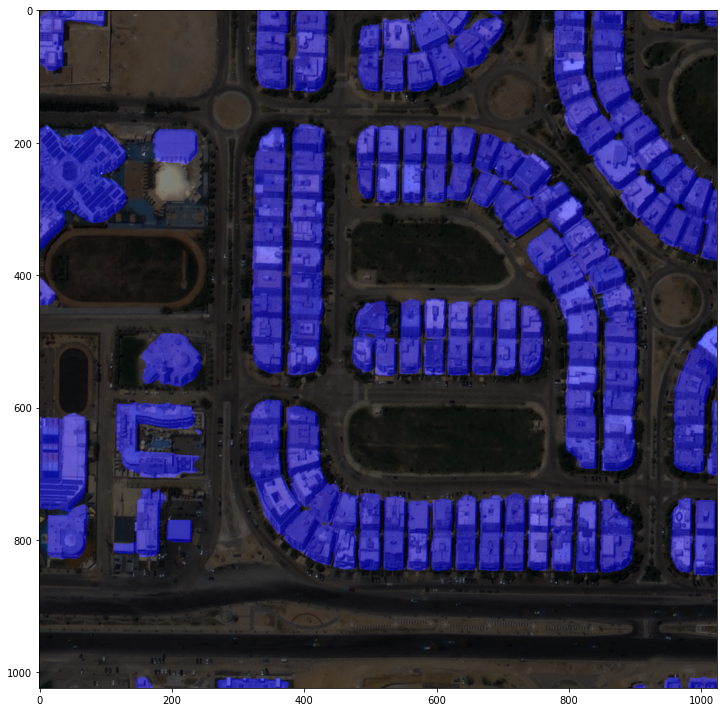

In [17]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_ce_dice_focal_lovasz/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00051_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_ce_dice_focal_lovasz/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


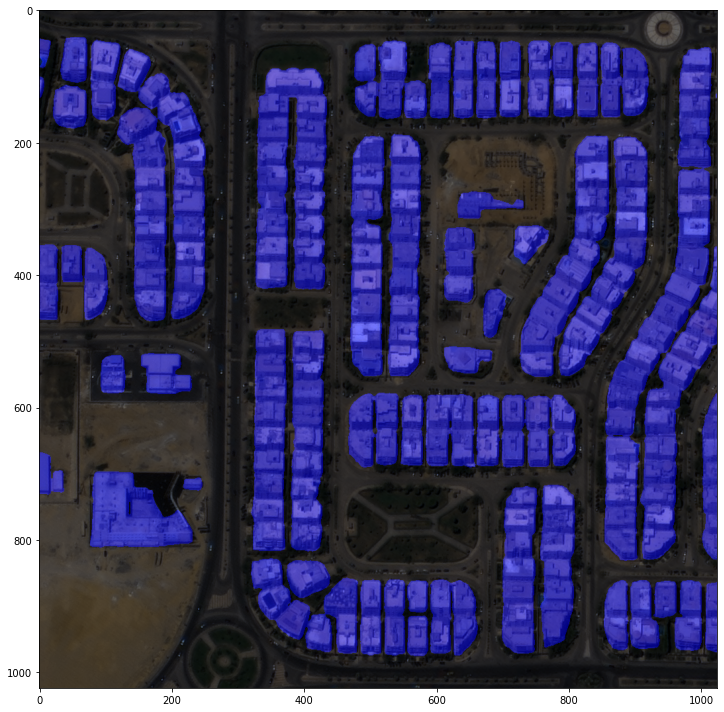

In [18]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_ce_dice_focal_lovasz/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00126_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_ce_dice_focal_lovasz/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


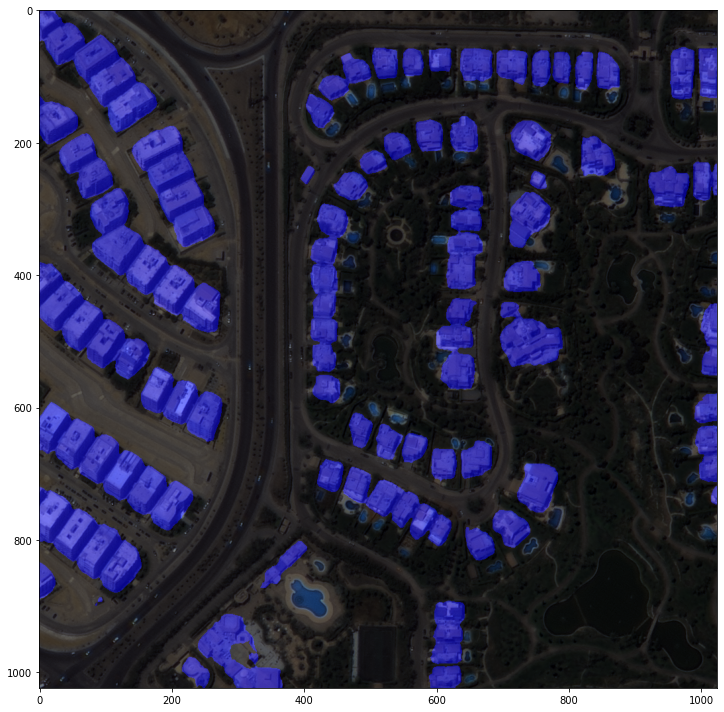

In [19]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_ce_dice_focal_lovasz/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00226_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_ce_dice_focal_lovasz/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


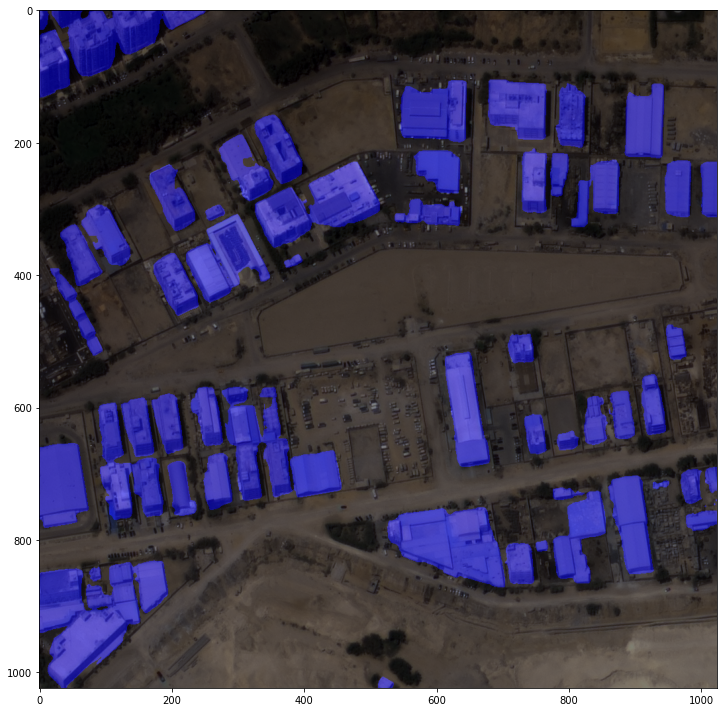

In [20]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_ce_dice_focal_lovasz/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00333_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)